In [ ]:
#CELDA 0
# ACIF104 — Semana 6 — Grupo 1
# Notebook final fusionado (v2 + versión 8)
# Incluye:
# - EDA completo
# - Split 70/15/15 reproducible
# - Preprocesamiento con ColumnTransformer
# - Modelos ML (LogReg, RF, XGB) con SMOTE
# - Modelo Deep Learning (MLP) con Keras/TensorFlow
# - Métricas, curvas y matriz de confusión
#
# Requisito: colocar Sleep_dataset.csv en la misma carpeta de este notebook.


In [1]:
#CELDA 0 — Encabezado
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


In [2]:
#CELDA 2 — Carga del dataset y limpieza básica (REQ1)
# Cargar el dataset (mismo directorio del notebook)
df = pd.read_csv("Sleep_dataset.csv")

print("Dimensiones iniciales:", df.shape)
df.head()

# Información general
df.info()
# Revisar valores nulos por columna
df.isnull().sum()
# Eliminar filas sin etiqueta en Sleep Disorder (para clasificación)
df = df.dropna(subset=["Sleep Disorder"])

# Person ID no aporta al modelo
if "Person ID" in df.columns:
    df = df.drop(columns=["Person ID"])

print("Dimensiones después de limpieza:", df.shape)
df.head()



Dimensiones iniciales: (374, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
6,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
16,Female,29,Nurse,6.5,5,40,7,Normal Weight,132/87,80,4000,Sleep Apnea


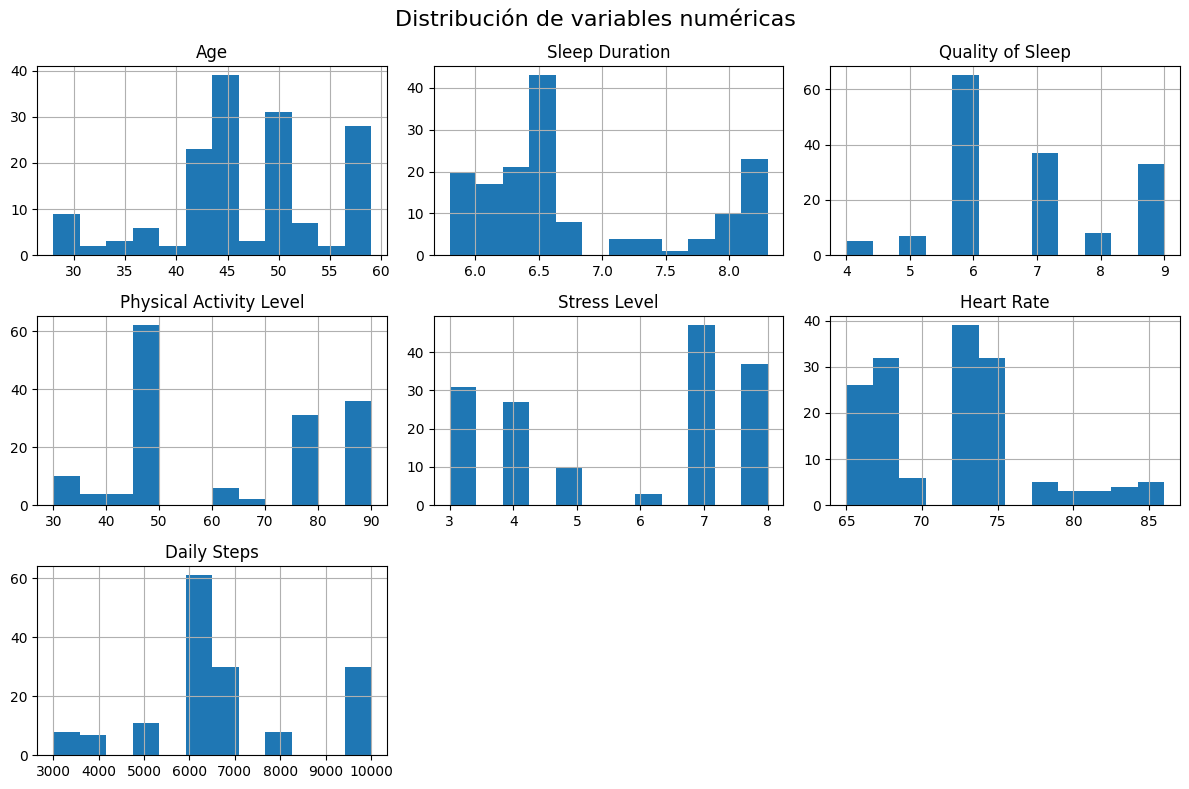

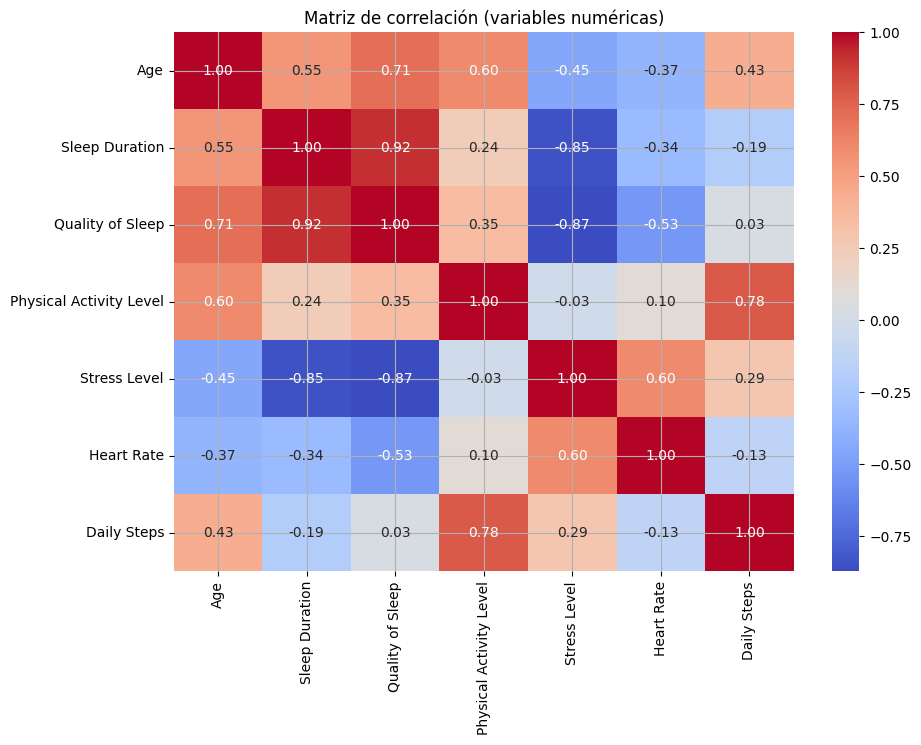

In [3]:
#CELDA 3 — EDA numérico: histogramas, boxplots, correlación (REQ1)
numeric_cols = [
    "Age",
    "Sleep Duration",
    "Quality of Sleep",
    "Physical Activity Level",
    "Stress Level",
    "Heart Rate",
    "Daily Steps"
]

df[numeric_cols].describe()
# Histogramas variables numéricas
df[numeric_cols].hist(bins=12, figsize=(12, 8))
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()
# Matriz de correlación
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación (variables numéricas)")
plt.show()


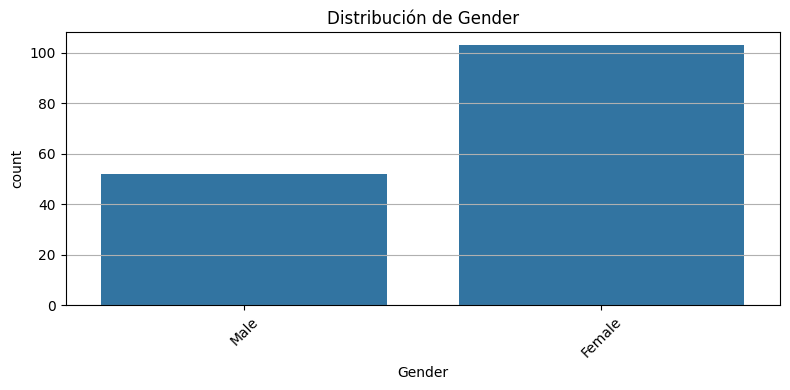

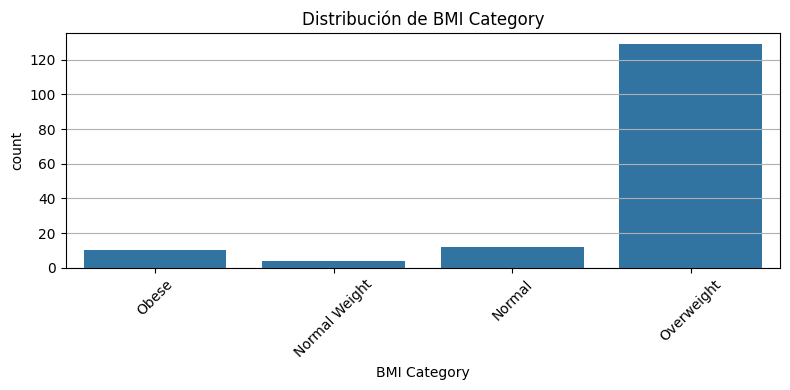

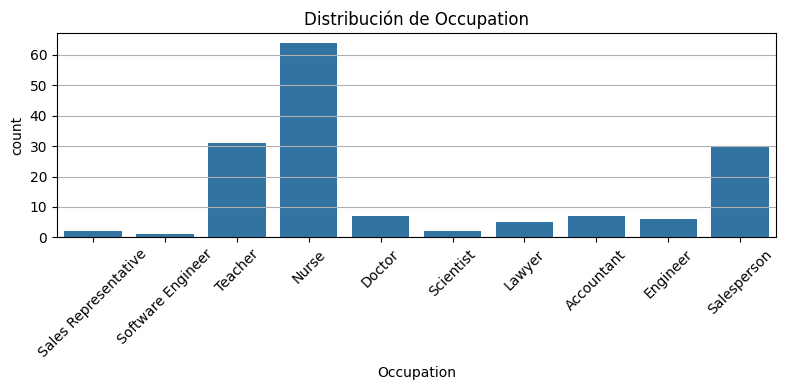

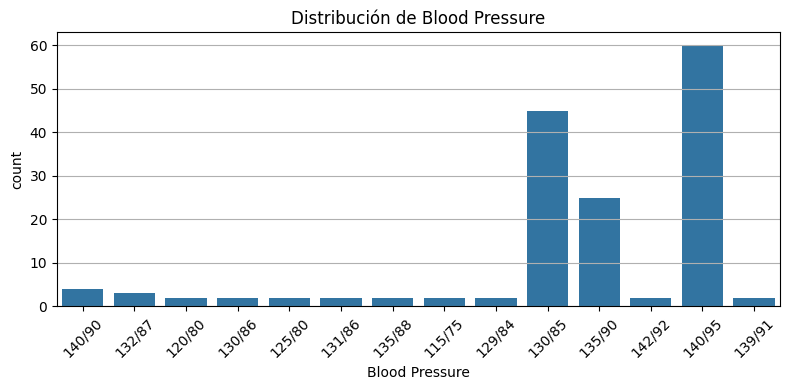

In [4]:
#CELDA 4 — EDA categórico (REQ1)
cat_cols = ["Gender", "BMI Category", "Occupation", "Blood Pressure"]
for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=df[col])
        plt.title(f"Distribución de {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [ ]:
#CELDA 5 — Definición de X, Y, columnas y preprocesamiento (REQ1)
# Variable objetivo
y = df["Sleep Disorder"]
X = df.drop(columns=["Sleep Disorder"])

numeric_cols = [
    "Age",
    "Sleep Duration",
    "Quality of Sleep",
    "Physical Activity Level",
    "Stress Level",
    "Heart Rate",
    "Daily Steps"
]

categorical_cols = ["Gender", "Occupation", "BMI Category", "Blood Pressure"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

X.head()


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000
5,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000
6,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500
16,Female,29,Nurse,6.5,5,40,7,Normal Weight,132/87,80,4000


In [6]:
#CELDA 6 — Split 70/15/15 (train/val/test) con estratificación (REQ1)
# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Distribución y_train:")
print(y_train.value_counts())


Train: (108, 11) Val: (23, 11) Test: (24, 11)
Distribución y_train:
Sleep Disorder
Sleep Apnea    54
Insomnia       54
Name: count, dtype: int64


In [7]:
#CELDA 7 — Balanceo con SMOTE (para ML en pipeline) (REQ1)
smote = SMOTE(random_state=42)
smote


,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5


In [8]:
#CELDA 8 — Helper para evaluación de modelos ML
def evaluar_modelo(nombre, y_true, y_pred):
    print(f"\n=== {nombre} ===")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión — {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()



=== Regresión Logística ===
              precision    recall  f1-score   support

    Insomnia       0.85      0.92      0.88        12
 Sleep Apnea       0.91      0.83      0.87        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24



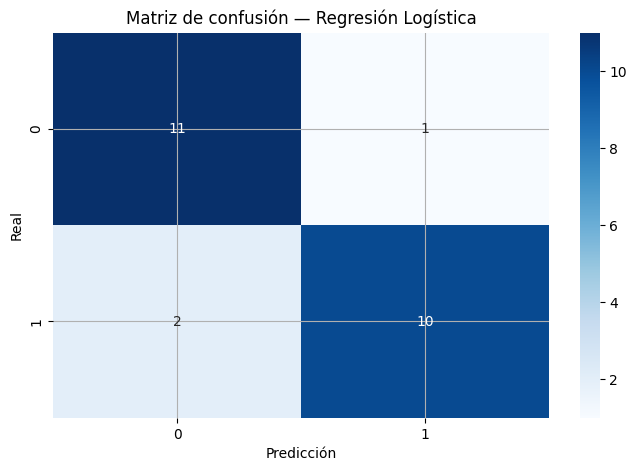


=== Random Forest ===
              precision    recall  f1-score   support

    Insomnia       0.85      0.92      0.88        12
 Sleep Apnea       0.91      0.83      0.87        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24



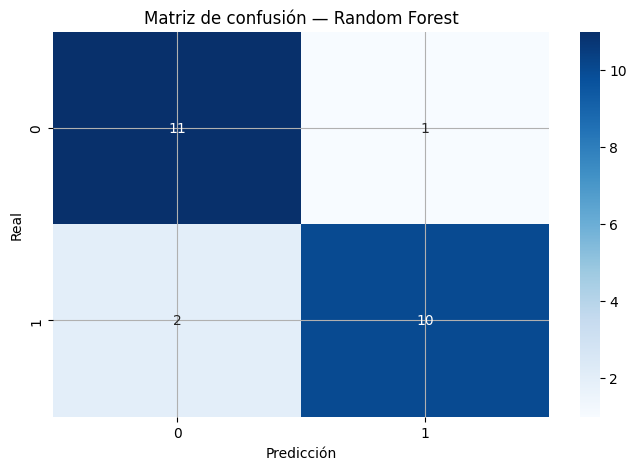

In [12]:
#CELDA 9 — Modelos ML: Regresión Logística, Random Forest, XGBoost (REQ1)
from sklearn.metrics import f1_score

resultados_ml = []

# 1) Regresión Logística
logreg_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=300, class_weight="balanced"))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_log = logreg_pipeline.predict(X_test)
evaluar_modelo("Regresión Logística", y_test, y_pred_log)

f1_log = f1_score(y_test, y_pred_log, average="macro")
resultados_ml.append(("Logistic Regression", f1_log))

# 2) Random Forest
rf_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=250,
        class_weight="balanced",
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
evaluar_modelo("Random Forest", y_test, y_pred_rf)

f1_rf = f1_score(y_test, y_pred_rf, average="macro")
resultados_ml.append(("Random Forest", f1_rf))






=== XGBoost ===
              precision    recall  f1-score   support

    Insomnia       0.83      0.83      0.83        12
 Sleep Apnea       0.83      0.83      0.83        12

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24



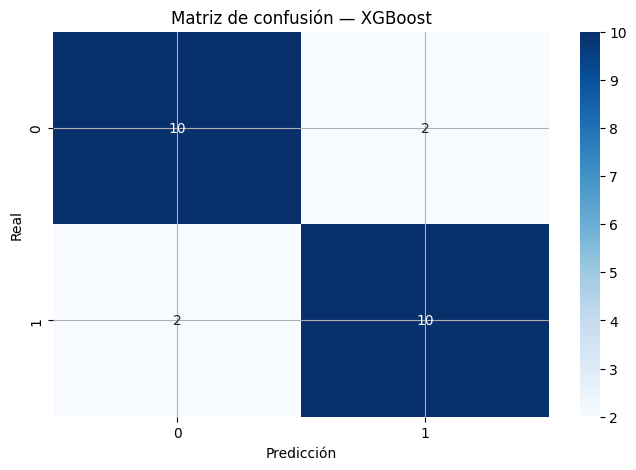

[('Logistic Regression', 0.8747826086956522),
 ('Random Forest', 0.8747826086956522),
 ('XGBoost', 0.8333333333333334)]

In [14]:
from sklearn.preprocessing import LabelEncoder

# codificar etiquetas
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc  = label_encoder.transform(y_test)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", xgb_model)
])

xgb_pipeline.fit(X_train, y_train_enc)
y_pred_xgb_enc = xgb_pipeline.predict(X_test)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_enc)

evaluar_modelo("XGBoost", y_test, y_pred_xgb)

f1_xgb = f1_score(y_test, y_pred_xgb, average="macro")
resultados_ml.append(("XGBoost", f1_xgb))
resultados_ml


In [15]:
#CELDA 10 — Preparación específica para el MLP (REQ2)
# Encode de etiquetas para el MLP
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)
print("Clases:", dict(zip(range(num_classes), le.classes_)))


Clases: {0: 'Insomnia', 1: 'Sleep Apnea'}


In [16]:
# Ajustar el ColumnTransformer solo con X_train
preprocess.fit(X_train)

# Transformar a matrices densas para Keras
X_train_proc = preprocess.transform(X_train).toarray()
X_val_proc   = preprocess.transform(X_val).toarray()
X_test_proc  = preprocess.transform(X_test).toarray()

X_train_proc.shape, X_val_proc.shape, X_test_proc.shape


((108, 37), (23, 37), (24, 37))

In [32]:
#CELDA 11 — Definición y entrenamiento del MLP (REQ2)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

input_dim = X_train_proc.shape[1]

model = Sequential([
    Dense(64, activation="relu", input_shape=(input_dim,)),
    Dense(32, activation="relu"),
    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,578 (17.88 KB)

 Trainable params: 4,578 (17.88 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.utils import to_categorical

# Convertir y_train_enc y y_val_enc a formato one-hot
y_train_ohe = to_categorical(y_train_enc, num_classes=num_classes)
y_val_ohe = to_categorical(y_val_enc, num_classes=num_classes)

# Entrenamiento del MLP
history = model.fit(
    X_train_proc, y_train_ohe,
    validation_data=(X_val_proc, y_val_ohe),
    epochs=50,
    batch_size=32,
    verbose=1
)



Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5000 - loss: 0.6790 - val_accuracy: 0.4783 - val_loss: 0.6310
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5926 - loss: 0.5801 - val_accuracy: 0.6522 - val_loss: 0.5762
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.5052 - val_accuracy: 0.8261 - val_loss: 0.5368
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8611 - loss: 0.4466 - val_accuracy: 0.8261 - val_loss: 0.5098
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9074 - loss: 0.4021 - val_accuracy: 0.7826 - val_loss: 0.4906
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9074 - loss: 0.3686 - val_accuracy: 0.7826 - val_loss: 0.4739
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9167 - loss: 0.3377 - val_accuracy: 0.7826 - val_loss: 0.4611
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9259 - loss: 0.3092 - val_accuracy: 0.7826 - val_loss: 0.4494


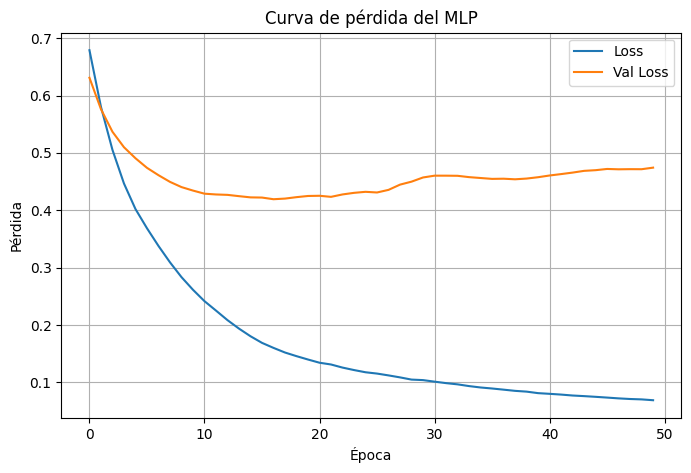

In [37]:
#CELDA 12 — Curvas de entrenamiento: Loss y Accuracy (REQ2)
# Curva de pérdida
plt.figure()
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Curva de pérdida del MLP")
plt.legend()
plt.show()


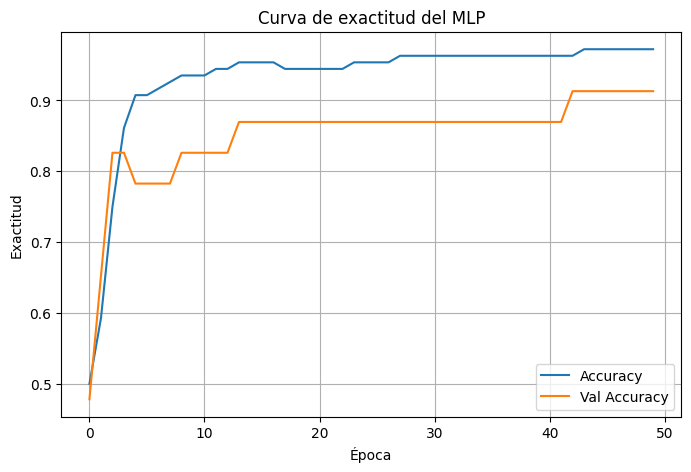

In [38]:
# Curva de exactitud
plt.figure()
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.title("Curva de exactitud del MLP")
plt.legend()
plt.show()


In [39]:
#CELDA 13 — Evaluación del MLP en test: matriz de confusión y reporte (REQ2)
# Predicciones en el conjunto de prueba
y_pred_prob = model.predict(X_test_proc)
y_pred_enc  = y_pred_prob.argmax(axis=1)

print("Accuracy MLP:", np.mean(y_pred_enc == y_test_enc))
print("\nClassification report MLP:")
print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Accuracy MLP: 0.8333333333333334

Classification report MLP:
              precision    recall  f1-score   support

    Insomnia       0.83      0.83      0.83        12
 Sleep Apnea       0.83      0.83      0.83        12

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24



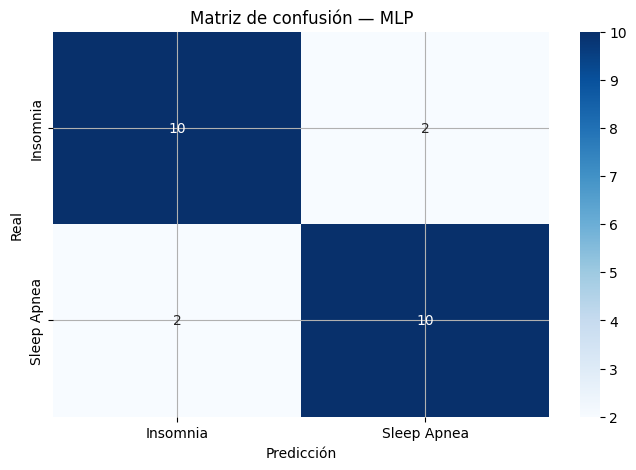

In [40]:
# Matriz de confusión del MLP
cm_mlp = confusion_matrix(y_test_enc, y_pred_enc)

sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Matriz de confusión — MLP")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [ ]:
#CELDA 14 — Comparación rápida ML vs DL
from statistics import mean

print("=== Resumen F1-Macro Modelos ML ===")
for nombre, f1 in resultados_ml:
    print(f"{nombre}: {f1:.2f}")

# Calcular F1 macro del MLP para comparar
from sklearn.metrics import f1_score
f1_mlp = f1_score(y_test_enc, y_pred_enc, average="macro")
print(f"\nMLP (Deep Learning) — F1-macro: {f1_mlp:.2f}")


=== Resumen F1-Macro Modelos ML ===
Logistic Regression: 0.87
Random Forest: 0.87
XGBoost: 0.83

MLP (Deep Learning) — F1-macro: 0.83


✔ REQ1 (Entorno, dataset, EDA, ML, preprocesamiento)

Carga correcta del dataset

Limpieza de datos + manejo de NaN en la variable objetivo

EDA numérico y categórico completo

Definición clara de numeric_cols y categorical_cols

Uso de ColumnTransformer con escalado y OneHot

División 70/15/15 estratificada y reproducible

Balanceo con SMOTE en los modelos ML

Modelos: Regresión Logística, Random Forest y XGBoost

Métricas y matrices de confusión para cada modelo

✔ REQ2 (Deep Learning)

MLP implementado con Keras (arquitectura explícita)

Preprocesamiento consistente con ML (mismas features transformadas)

LabelEncoder + OneHotEncoding de y

Entrenamiento con history (50 épocas, batch_size 32)

Curva de pérdida (loss vs val_loss)

Curva de accuracy (accuracy vs val_accuracy)

Matriz de confusión del MLP

Classification report del MLP

Comparación de F1-macro MLP vs modelos ML